# Flu Modeling Notebook 🦠

### Step One: Import Libraries 📚

In [244]:
# For Machine Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# To Track Training Progress
from tqdm import tqdm

# For Scalers and Metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For Plotting & Visualizations
import matplotlib.pyplot as plt

# For Data Prepocessing
import numpy as np
import pandas as pd

### Read In Data and Perform Preprocessing 📈

In [245]:
# Read-In Dataframe
path = "../Data/more_combined_data.csv"
df = pd.read_csv(path)
df.head()

,DATE,YEAR,WEEK,% WEIGHTED ILI,REGIONAL ILI BASELINE,ABOVE BASELINE,IS FLUWEEK,AGE 0-4,AGE 5-24,AGE 25-64,...,COOLING DAYS MONTHLY,HEATING DAYS MONTHLY,PRECIPITATION MONTHLY,AVG TEMP MONTHLY,POPULATION,VAXEFFECTIVENESS,VACCINERATENATIONAL,AWND,PRCP,TAVG
0,2003-10-05,2003,40,0.572031,0.782203,0,0,14,40,27,...,0.0,266.2,150.1,9.7,14182454,52,12.7,2.805714,1.808571,11.100000
1,2003-10-12,2003,41,0.449279,0.782203,0,0,6,35,35,...,0.0,266.2,150.1,9.7,14182454,52,12.7,2.480000,2.726190,12.740000
2,2003-10-19,2003,42,0.613789,0.782203,0,0,19,60,32,...,0.0,266.2,150.1,9.7,14182454,52,12.7,3.634286,5.311905,10.291429
3,2003-10-26,2003,43,0.661170,0.782203,0,0,32,56,33,...,0.0,266.2,150.1,9.7,14182454,52,12.7,3.974286,2.473333,7.068571
4,2003-11-02,2003,44,0.760914,0.782203,0,0,31,74,38,...,0.0,375.4,77.7,5.6,14182454,52,12.7,3.291429,9.711905,12.899286


In [246]:
# Convert 'DATE' to datetime and extract useful features
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month

# Introduce Lag Term & Drop NA Introduced By Lag
df['ILI_t+1'] = df['% WEIGHTED ILI'].shift(-1)
df = df.dropna()
df.drop("DATE", axis=1, inplace=True)

# Reorder the MONTH column to be the second column
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index('MONTH')))
df = df[cols]

# Re-Order Target to Last Col
cols.remove('ILI_t+1')
cols.append('ILI_t+1')
df = df[cols]

df.head()

# Initialize MinMax scalers for features and target
feature_scaler = PowerTransformer(method='yeo-johnson')
target_scaler = PowerTransformer(method='yeo-johnson')

# Identify columns to exclude from scaling
date_columns = ['MONTH', 'WEEK', 'YEAR']  # Add any other date-related columns here
non_target_columns = df.columns.difference(['ILI_t+1'] + date_columns)

# Separate features and target
features = df[non_target_columns]
target = df[['ILI_t+1']]

# Fit and transform features (excluding date columns) and scale the target separately
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features, date-related columns, and scaled target back into a DataFrame
scaled_df = df[date_columns].copy()
scaled_df[non_target_columns] = scaled_features
scaled_df['ILI_t+1'] = scaled_target

scaled_df.head()

,MONTH,WEEK,YEAR,% WEIGHTED ILI,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),ABOVE BASELINE,AGE 0-4,...,POPULATION,PRCP,PRECIPITATION MONTHLY,REGIONAL ILI BASELINE,TAVG,TOTAL PATIENTS,TOTAL SPECIMENS,VACCINERATENATIONAL,VAXEFFECTIVENESS,ILI_t+1
0,10,40,2003,-0.466725,-0.789764,-0.32046,-0.979889,-1.031766,-0.664602,-1.241429,...,-1.488366,-0.291545,1.250643,-1.509825,0.202051,-1.121061,-2.408024,-1.92444,0.784185,-0.795809
1,10,41,2003,-0.794792,-0.789764,-0.32046,-0.979889,-1.031766,-0.664602,-1.656241,...,-1.488366,0.145861,1.250643,-1.509825,0.367209,-0.927216,-2.005260,-1.92444,0.784185,-0.368833
2,10,42,2003,-0.367585,-0.789764,-0.32046,-0.979889,-1.031766,-0.664602,-1.060470,...,-1.488366,0.942170,1.250643,-1.509825,0.119837,-0.916846,-1.774457,-1.92444,0.784185,-0.263003
3,10,43,2003,-0.261717,-0.789764,-0.32046,-0.979889,-1.031766,-0.664602,-0.708685,...,-1.488366,0.037815,1.250643,-1.509825,-0.214073,-0.846701,-1.697827,-1.92444,0.784185,-0.060572
4,11,44,2003,-0.059239,-0.789764,-0.32046,-0.188333,-1.031766,-0.664602,-0.731746,...,-1.488366,1.716901,-0.386884,-1.509825,0.383145,-0.738967,-1.651640,-1.92444,0.784185,0.145713


In [247]:
scaled_df.dtypes

MONTH                            int32
WEEK                             int64
YEAR                             int32
% WEIGHTED ILI                 float64
A (2009 H1N1)                  float64
A (H1)                         float64
A (H3)                         float64
A (Subtyping not Performed)    float64
ABOVE BASELINE                 float64
AGE 0-4                        float64
AGE 25-64                      float64
AGE 5-24                       float64
AGE 65                         float64
AVG TEMP MONTHLY               float64
AVG WIND SPEED MONTHLY         float64
AWND                           float64
B                              float64
Bvic                           float64
Byam                           float64
COOLING DAYS MONTHLY           float64
HEATING DAYS MONTHLY           float64
ILITOTAL                       float64
IS FLUWEEK                     float64
NUM. OF PROVIDERS              float64
POPULATION                     float64
PRCP                     

### Convert Pandas DF To Tensors 🔂

In [248]:
class Flu_Dataset(Dataset):
    def __init__(self):
        # Convert to Torch Tensors
        self.x = torch.tensor(scaled_features, dtype=torch.float32)
        self.y = torch.tensor(scaled_target, dtype=torch.float32)

    # Define mandatory length method
    def __len__(self):
        return len(self.y)
    
    # Define mandatory get item method
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # Split into train, validation, and test splits
    def split_data(self, train_ratio=0.7, val_ratio=0.1):
        n = len(self.x)
        train_end = int(train_ratio * n)
        val_end = int((train_ratio + val_ratio) * n)
        
        # Train, Validation, Test datasets
        train_dataset = torch.utils.data.Subset(self, range(0, train_end))
        val_dataset = torch.utils.data.Subset(self, range(train_end, val_end))
        test_dataset = torch.utils.data.Subset(self, range(val_end, n))
        
        return train_dataset, val_dataset, test_dataset

In [249]:
# Instantiate Class with Dataset
flu_df = Flu_Dataset()

# Split into 80/20 Train-Test
train_dataset, val_dataset, test_dataset = flu_df.split_data()

# Prepare DataLoaders
train = DataLoader(train_dataset, batch_size=128, shuffle=False)
test = DataLoader(test_dataset, batch_size=128, shuffle=False)
val = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Check splits and number of batches
print("Training Samples: ", len(train_dataset))
print("Testing Samples: ", len(test_dataset))
print("Number of Training Batches: ", len(train))
print("Number of Testing Batches: ", len(test))

Training Samples:  571
Testing Samples:  164
Number of Training Batches:  5
Number of Testing Batches:  2


### Build Initial GRU/CNN Model as Baseline 🛠️

In [250]:
class Build_Model(nn.Module):
    def __init__(self, input_size):
        super(Build_Model, self).__init__()
        self.conv1d = nn.Conv1d(in_channels = input_shape, out_channels = 512, kernel_size = 2, padding = 1)
 
        # Based on the Keras best model (Model E)
        self.gru1 = nn.GRU(input_size=512, hidden_size=256, bidirectional=True)
        self.dropout1 = nn.Dropout(0.8)
        
        self.gru2 = nn.GRU(input_size=512, hidden_size=256, bidirectional=True)
        self.dropout1 = nn.Dropout(0.70)

        self.selu = nn.SELU()

        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        x = x.permute(0, 2, 1)
        
        # Convolution Layer
        out = self.conv1d(x)
        out = out.permute(0, 2, 1)
        
        # GRU layers
        out, _ = self.gru1(out)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)

        # Take the last time step
        out = out[:, -1, :]

        # Final output / FC Layers
        out = self.selu(out)
        out = self.fc(out)
        return out

### Train Initial Model 🔋

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


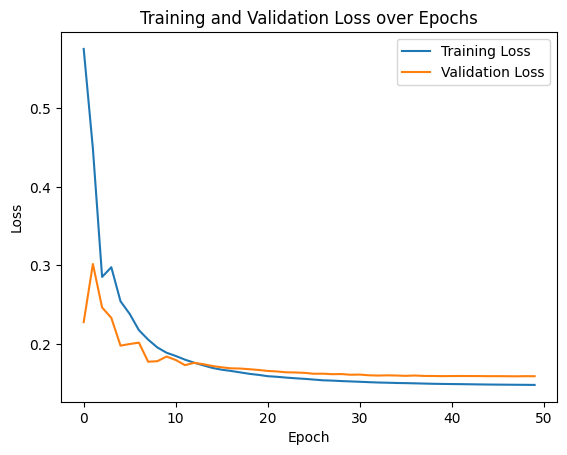

In [251]:
input_shape = 30
num_epochs = 50

# Initialize model
model = Build_Model(input_size=30)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True, weight_decay=0.001)
criterion = nn.L1Loss()

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=5)

# Training and validation loss tracking
loss_values = []
val_loss_values = []

model.train()
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    val_loss = 0

    # Training loop
    for batch_features, batch_labels in train:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in val:
            val_outputs = model(batch_features)
            val_loss += criterion(val_outputs, batch_labels).item()

    # Average losses
    avg_loss = epoch_loss / len(train)
    avg_val_loss = val_loss / len(val)

    loss_values.append(avg_loss)
    val_loss_values.append(avg_val_loss)

    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)

# Plot Training and Validation Loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

### Evaluate Initial Model 🧐

Average MAE on Test Data: 0.1200
Sample Predictions vs Actual Values:
Predicted: 1.5094, Actual: 1.7103
Predicted: 1.4959, Actual: 1.5764
Predicted: 1.3886, Actual: 1.6258
Predicted: 1.2150, Actual: 1.1334
Predicted: 0.9917, Actual: 1.0561


/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/noahgallego/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


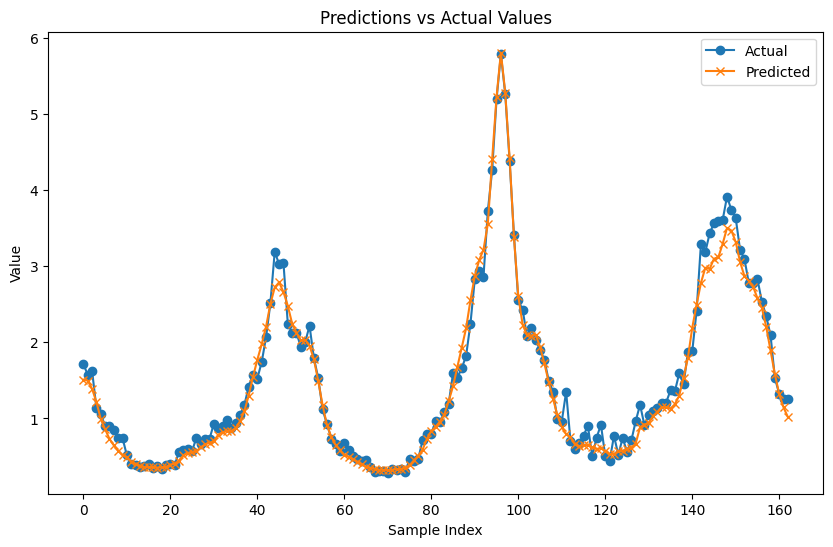

In [253]:
def evaluate_model(model, test, criterion, scaler):
    model.eval()  # Set the model to evaluation mode
    mae_values = []
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch_features, batch_labels in test:
            outputs = model(batch_features)
            
            # Inverse scaling
            outputs_np = outputs.cpu().numpy().reshape(-1, 1)
            labels_np = batch_labels.cpu().numpy().reshape(-1, 1)
            
            outputs_unscaled = scaler.inverse_transform(outputs_np)
            labels_unscaled = scaler.inverse_transform(labels_np)
            
            # Compute MAE on unscaled values
            mae = mean_absolute_error(labels_unscaled, outputs_unscaled)
            mae_values.append(mae)
            
            # Collect predictions and actuals for comparison
            all_predictions.extend(outputs_unscaled.flatten())
            all_actuals.extend(labels_unscaled.flatten())
    
    avg_mae = mean_absolute_error(all_actuals, all_predictions)
    return avg_mae, all_predictions, all_actuals

# Assuming 'scaler' is your fitted scaler used during preprocessing
avg_mae, predictions, actuals = evaluate_model(model, test, criterion, target_scaler)
print(f"Average MAE on Test Data: {avg_mae:.4f}")

# Display a sample of predictions and actual values
sample_size = 5
print("Sample Predictions vs Actual Values:")
for i in range(sample_size):
    print(f"Predicted: {predictions[i]:.4f}, Actual: {actuals[i]:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(actuals[:-1], label='Actual', marker='o')
plt.plot(predictions[:-1], label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()